In [1]:
import os
import re

import pandas as pd
import numpy as np

from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
import seaborn as sns

import util as util
import metrics as mt
from lamp import Lamp
from itertools import product

In [2]:
# Diretório onde estão os arquivos .pt
diretorio = './data/diabetes/NN/feature_importance/'

attr = {}
# Percorre todos os arquivos no diretório
for nome_arquivo in os.listdir(diretorio):
    # Verifica se o arquivo é um arquivo .pt
    if nome_arquivo.endswith('.csv'):
        # Cria o caminho completo para o arquivo
        caminho_arquivo = os.path.join(diretorio, nome_arquivo)
        # Carrega
        df = pd.read_csv(caminho_arquivo)
        # Add no dicionario
        method_name = re.search('(.+?).csv', nome_arquivo)
        attr[method_name.group(1)] = df
        # Faz algo com o modelo (por exemplo, usar para inferência)
        print(f"Arquivo {nome_arquivo} carregado com sucesso!")

Arquivo DeepLift.csv carregado com sucesso!
Arquivo Guided_Backprop.csv carregado com sucesso!
Arquivo Input_X_Gradient.csv carregado com sucesso!
Arquivo Integrated_Gradients.csv carregado com sucesso!
Arquivo KernelShap.csv carregado com sucesso!
Arquivo Lime.csv carregado com sucesso!
Arquivo Occlusion.csv carregado com sucesso!
Arquivo ShapleyValueSampling.csv carregado com sucesso!
Arquivo SmoothGrad.csv carregado com sucesso!
Arquivo Vanilla_Gradients.csv carregado com sucesso!


In [3]:
attr.keys()

dict_keys(['DeepLift', 'Guided_Backprop', 'Input_X_Gradient', 'Integrated_Gradients', 'KernelShap', 'Lime', 'Occlusion', 'ShapleyValueSampling', 'SmoothGrad', 'Vanilla_Gradients'])

In [4]:
explanation_methods = ['Integrated_Gradients',
                       'Input_X_Gradient', 
                       'SmoothGrad',
                       'Vanilla_Gradients', 
                       'Guided_Backprop',
                       'Occlusion',
                       'Lime', 
                       'KernelShap',
                       'DeepLift',
                       #'FeatureAblation', 
                       #'FeaturePermutation',
                       'ShapleyValueSampling',
          ]

In [5]:
def get_dict_topk(dict_attributions, list_methods, k=5):
    
    dict_topk = {}
    
    for method_name in list_methods:
        dict_topk[method_name] = mt.get_top_k(dict_attributions[method_name], k)        
    
    return dict_topk

In [6]:
def calc_metrics(ranking_size, methods, metric, dict_topk):
    
    # recuperando apenas o topk dos métodos de explicação indicados
    dict_topk = {k: v for k, v in dict_topk.items() if k in methods}
    
    #num_instancias do dataset
    first_element = next(iter(dict_topk.items()))
    num_instancias = len(first_element[1])
    
    # Matriz de pontos com as combinações dos métodos de explicação para a função feature agreement
    matrix_points, list_combinations_methods = mt.create_matrix_combination_methdos_by_metric(dict_topk, metric, num_instancias, methods)
    
    
    return matrix_points, list_combinations_methods

In [7]:
list_metrics = {
    "feature agreement": mt.feature_agreement,
#     "rank agreement": mt.rank_agreement,
    "sign agreement": mt.sign_agreement,
#     "signed rank agreement": mt.sign_rank_agreement,
}

In [8]:
def draw_lamp(matrix_points, ax):
    
    df_ds = pd.DataFrame(matrix_points)
    n_ds = df_ds.shape[0]
    
    ################### LAMP calc
    # creating the control points
    sample_size = matrix_points.shape[1] #Número de combinações, por enquanto é sempre 6
    table = list(product([0, 1], repeat=sample_size))
    ctp_samples = []
    for i in table:
        ctp_samples.append(list(i))
        
    #transformando os pontos de controle de lista para numpy array
    ctp_samples = np.asarray(ctp_samples)

    control_points_samples = np.array(ctp_samples) #NEW
    df_ctp_5d = pd.DataFrame(control_points_samples)
    n_5d = df_ctp_5d.shape[0]

    cp_positions__ = util.control_points_position_v2(control_points_samples)
    df_ctp_2d = pd.DataFrame(cp_positions__)

    df_ds_cct = pd.concat([df_ds, df_ctp_5d], ignore_index=True)

    ids = np.arange(n_ds,n_ds+n_5d)
    df_ctp_2d[2] = ids

    ctp_2d = df_ctp_2d.values
    data = df_ds_cct.values

    lamp_proj = Lamp(Xdata = data, control_points = ctp_2d, label=False)
    data_proj = lamp_proj.fit()
    cp_positions = np.asarray(cp_positions__)

    #build lamp plot
    size_dataset = len(matrix_points)
    df = pd.DataFrame(data_proj[:size_dataset,:], columns=['Comp_1','Comp_2'])
    df['Class'] = 'Original'
    df2 = pd.DataFrame(cp_positions__, columns=['Comp_1','Comp_2'])
    df2['Class'] = 'Control Point'
    # Filtrando os pontos de controle para mostrar apenas o 0,0 e 1,1
    # Se desejar mostrar todos, basta remover essa linha
    df2 = df2.iloc[[0, len(df2)-1]] 
    
    df = pd.concat([df, df2])
    df = df.reset_index()
    df['Index'] = df.index    
    
    g = sns.scatterplot(data=df, x="Comp_1", y="Comp_2", hue="Class", ax=ax)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    return g, df
    

# Case 1: Gradient based explanation methods

In [9]:
explanation_methods

['Integrated_Gradients',
 'Input_X_Gradient',
 'SmoothGrad',
 'Vanilla_Gradients',
 'Guided_Backprop',
 'Occlusion',
 'Lime',
 'KernelShap',
 'DeepLift',
 'ShapleyValueSampling']

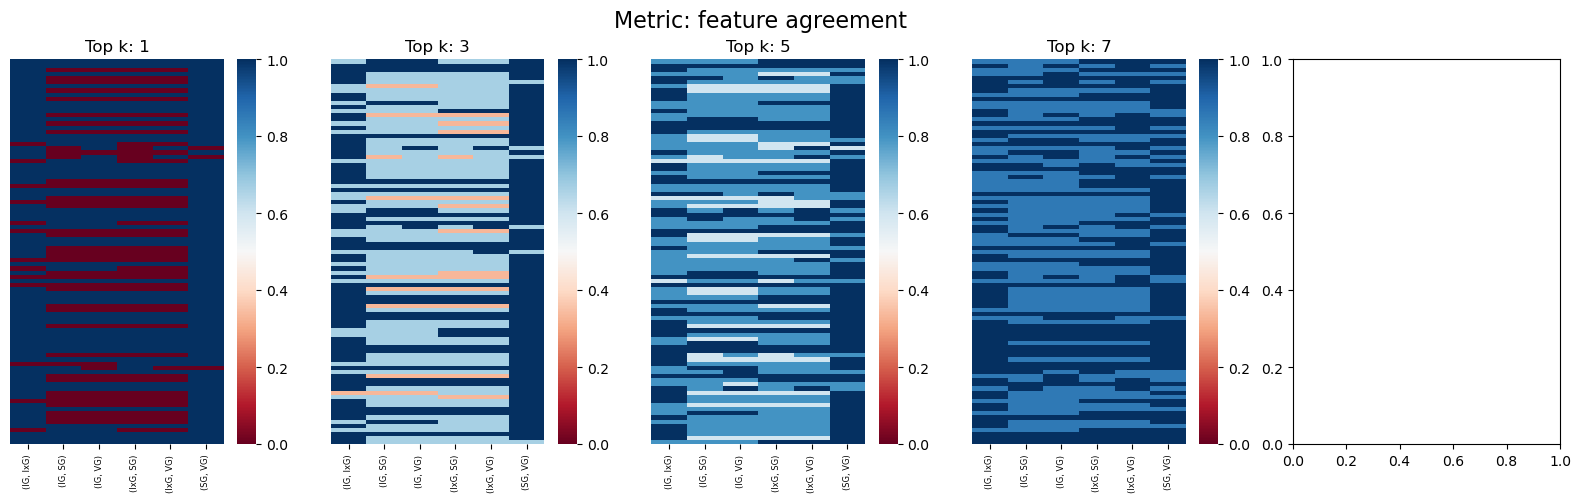

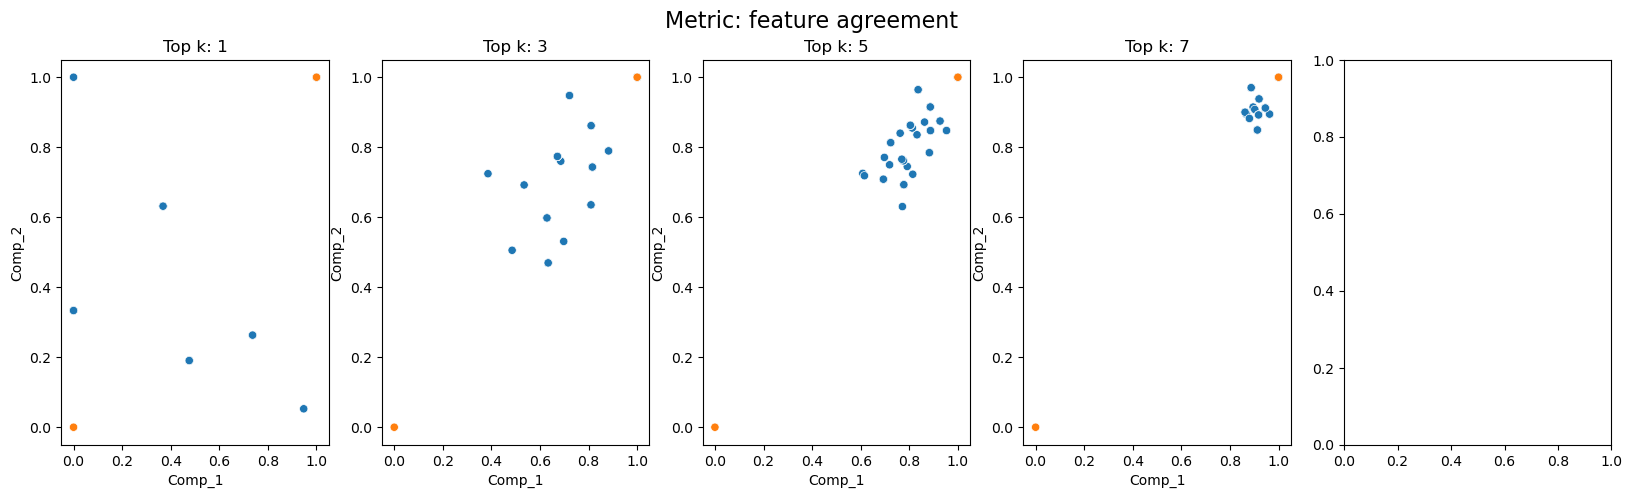

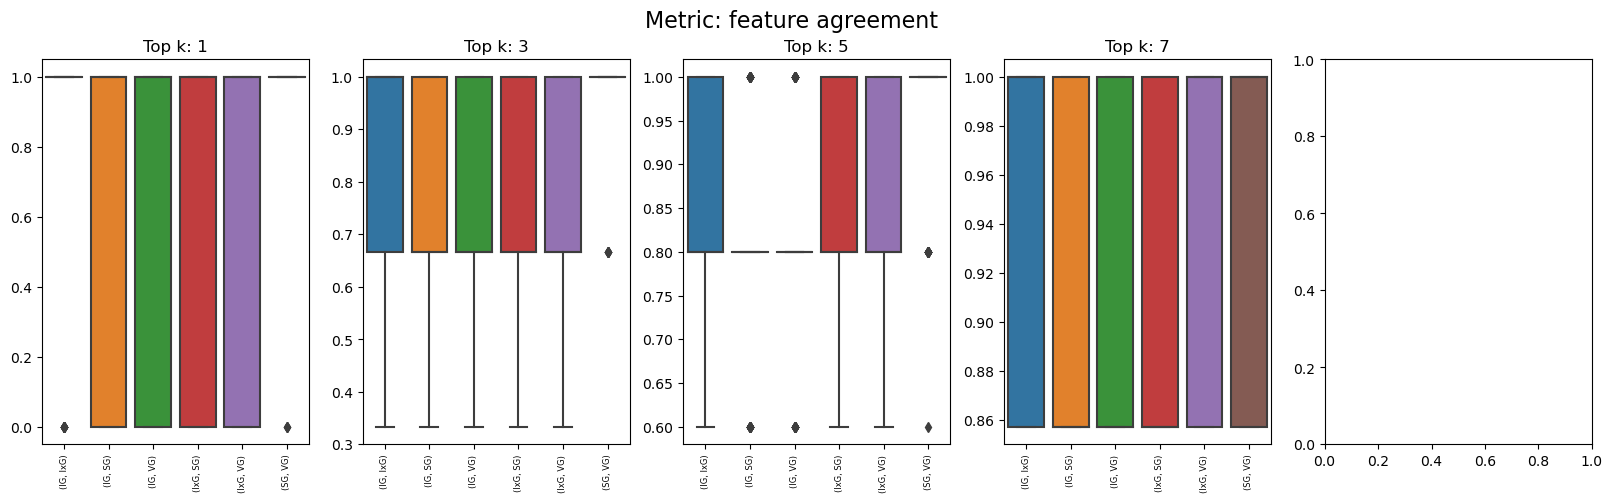

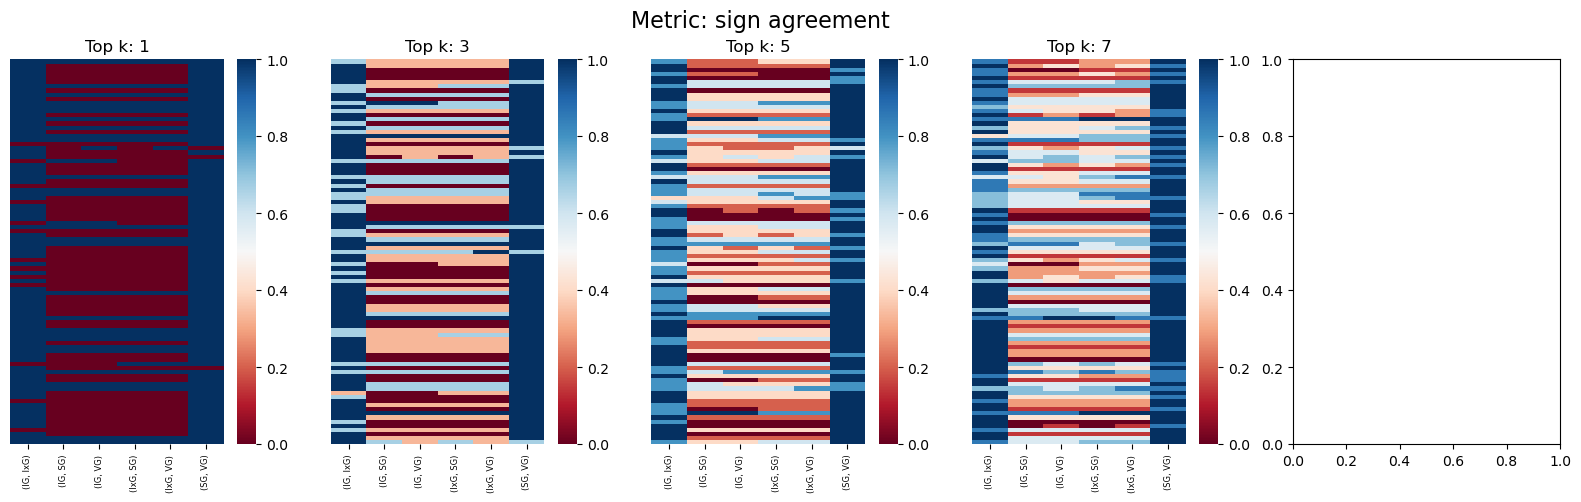

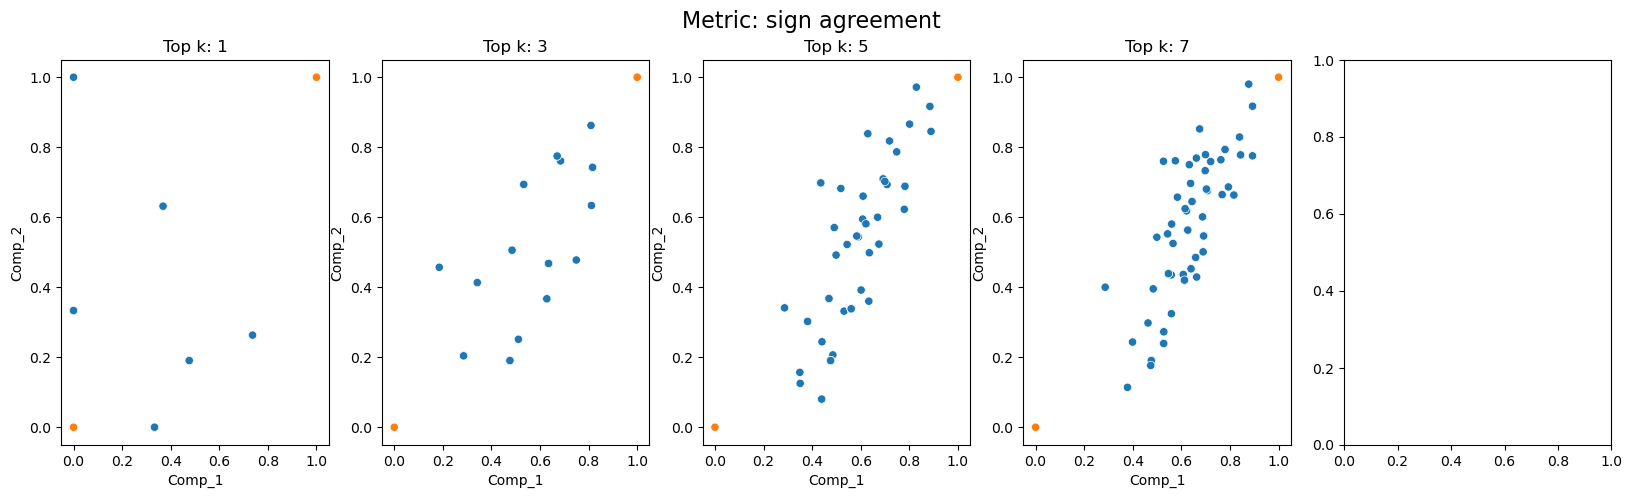

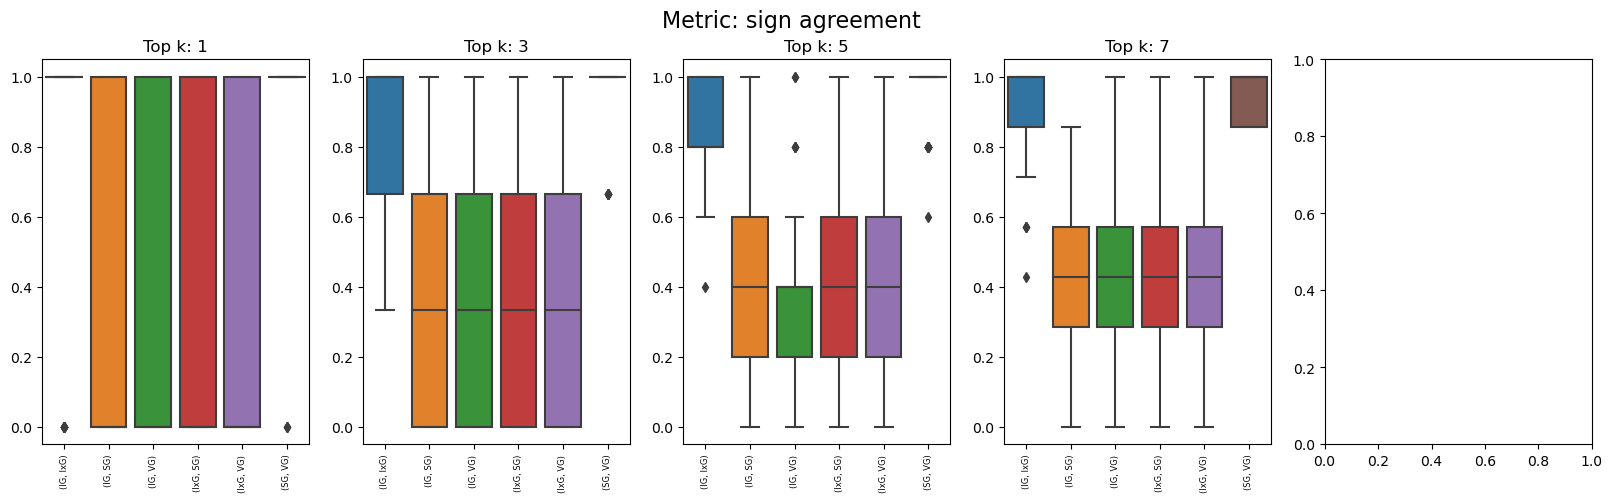

In [10]:
selected_methods = [explanation_methods[0], explanation_methods[1], explanation_methods[2], explanation_methods[3]]

# selected_metric= mt.feature_agreement


dfs = {}

for metric_name, selected_metric in list_metrics.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig_space, axs_space = plt.subplots(1, 5, figsize=(20, 5))
    fig_boxplot, axs_boxplot = plt.subplots(1, 5, figsize=(20, 5))
    
    i = 0
    df_k = {}
    for selected_k in [1,3,5,7]:
        dict_topk = get_dict_topk(attr, explanation_methods, selected_k)
        matrix_points, list_combinations_methods = calc_metrics(selected_k, selected_methods, selected_metric, dict_topk)
        xticklabels = ['(IG, IxG)', '(IG, SG)', '(IG, VG)', '(IxG, SG)', '(IxG, VG)', '(SG, VG)']
        name_combinations_methods = [str(t) for t in list_combinations_methods]
        df = pd.DataFrame(matrix_points, columns=name_combinations_methods)
        
        df_k[selected_k] = df
        
        sns.heatmap(df, cmap='RdBu', ax=axs[i], vmax=1, vmin=0, xticklabels=xticklabels)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 90, fontsize = 6)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_title('Top k: ' + str(selected_k))        
        
        _, df_lamp = draw_lamp(matrix_points, axs_space[i])
        axs_space[i].set_title('Top k: ' + str(selected_k))
        
        sns.boxplot(data=df, ax=axs_boxplot[i])
        axs_boxplot[i].set_title('Top k: ' + str(selected_k))      
        axs_boxplot[i].set_xticklabels(xticklabels, rotation = 90, fontsize = 6)
        
        i+=1
    
    dfs[metric_name] = df_k
    fig.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_space.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_boxplot.suptitle('Metric: ' + metric_name, fontsize=16)
    plt.show()

In [11]:
print(max(attr['Integrated_Gradients'].loc[1], key=abs))
attr['Integrated_Gradients'].loc[1]

-0.1686771043278856


no_times_pregnant       -0.081968
glucose_concentration   -0.168677
blood_pressure          -0.008782
skin_fold_thickness      0.013255
serum_insulin            0.035683
bmi                      0.139227
diabetes pedigree       -0.004203
age                     -0.142779
Name: 1, dtype: float64

In [12]:
print(max(attr['SmoothGrad'].loc[1], key=abs))
attr['SmoothGrad'].loc[1]

0.14078334


no_times_pregnant        0.053003
glucose_concentration    0.140783
blood_pressure          -0.021588
skin_fold_thickness      0.015161
serum_insulin           -0.040464
bmi                      0.111655
diabetes pedigree        0.018233
age                      0.099557
Name: 1, dtype: float64

In [13]:
df_temp = dfs['feature agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
# df_temp[df_temp['mean'] > 0.9].shape
fa_list = df_temp[df_temp['mean'] > 0.9].index.values
df_temp[df_temp['mean'] > 0.9]

,"('Integrated_Gradients', 'Input_X_Gradient')","('Integrated_Gradients', 'SmoothGrad')","('Integrated_Gradients', 'Vanilla_Gradients')","('Input_X_Gradient', 'SmoothGrad')","('Input_X_Gradient', 'Vanilla_Gradients')","('SmoothGrad', 'Vanilla_Gradients')",mean
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
df_temp = dfs['sign agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
# df_temp[df_temp['mean'] > 0.9].shape
sa_list = df_temp[df_temp['mean'] > 0.9].index.values
df_temp[df_temp['mean'] > 0.9]

,"('Integrated_Gradients', 'Input_X_Gradient')","('Integrated_Gradients', 'SmoothGrad')","('Integrated_Gradients', 'Vanilla_Gradients')","('Input_X_Gradient', 'SmoothGrad')","('Input_X_Gradient', 'Vanilla_Gradients')","('SmoothGrad', 'Vanilla_Gradients')",mean
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14,1.0,1.0,1.0,1.0,1.0,1.0,1.0
16,1.0,1.0,1.0,1.0,1.0,1.0,1.0
18,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
np.array(list(set(fa_list)-set(sa_list)))

array([ 1,  3, 25, 26, 27, 36, 37, 38, 49, 53, 57, 58, 61, 63, 68, 72, 84,
       88, 90], dtype=int64)

In [16]:
np.array(list(set(fa_list).intersection(set(sa_list))))

array([ 0,  6,  8, 10, 11, 12, 14, 16, 18, 19, 28, 31, 32, 40, 43, 44, 56,
       62, 65, 66, 67, 69, 70, 75, 78, 79, 91, 92], dtype=int64)

feature agreement
1
('Integrated_Gradients', 'Input_X_Gradient')     0.860215
('Integrated_Gradients', 'SmoothGrad')           0.569892
('Integrated_Gradients', 'Vanilla_Gradients')    0.580645
('Input_X_Gradient', 'SmoothGrad')               0.526882
('Input_X_Gradient', 'Vanilla_Gradients')        0.537634
('SmoothGrad', 'Vanilla_Gradients')              0.967742
dtype: float64
3
('Integrated_Gradients', 'Input_X_Gradient')     0.899642
('Integrated_Gradients', 'SmoothGrad')           0.727599
('Integrated_Gradients', 'Vanilla_Gradients')    0.738351
('Input_X_Gradient', 'SmoothGrad')               0.709677
('Input_X_Gradient', 'Vanilla_Gradients')        0.724014
('SmoothGrad', 'Vanilla_Gradients')              0.978495
dtype: float64
5
('Integrated_Gradients', 'Input_X_Gradient')     0.892473
('Integrated_Gradients', 'SmoothGrad')           0.804301
('Integrated_Gradients', 'Vanilla_Gradients')    0.806452
('Input_X_Gradient', 'SmoothGrad')               0.812903
('Input_X_Gradient

[]

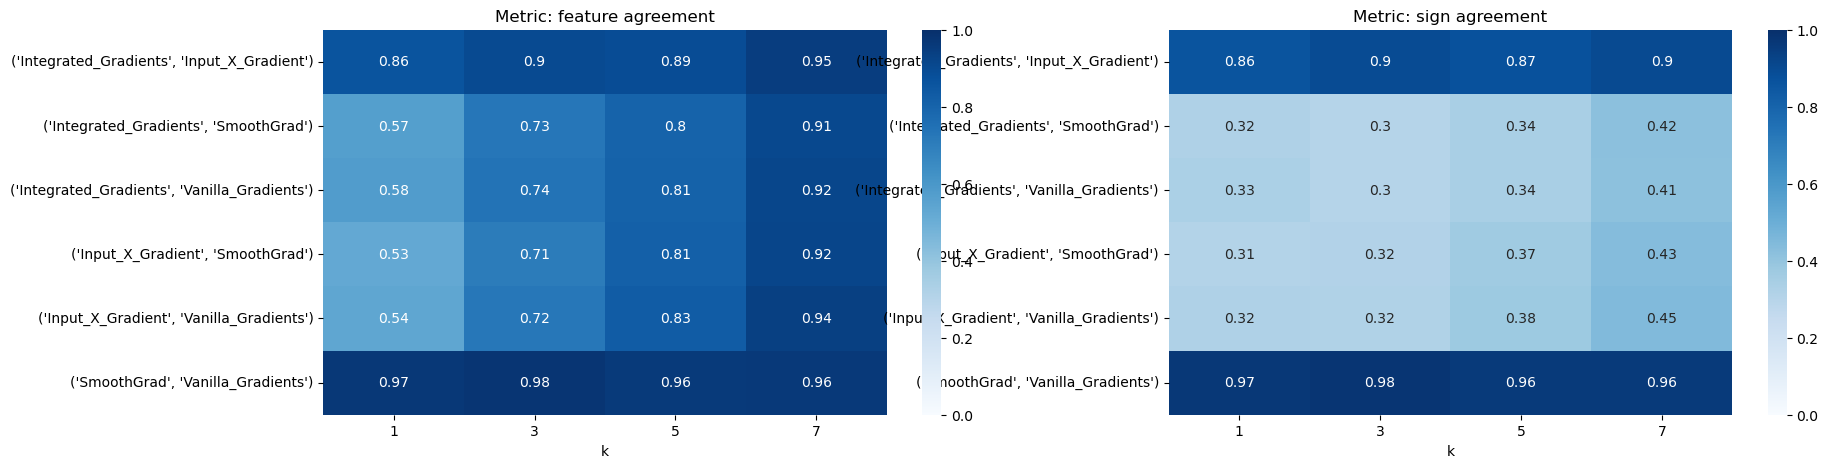

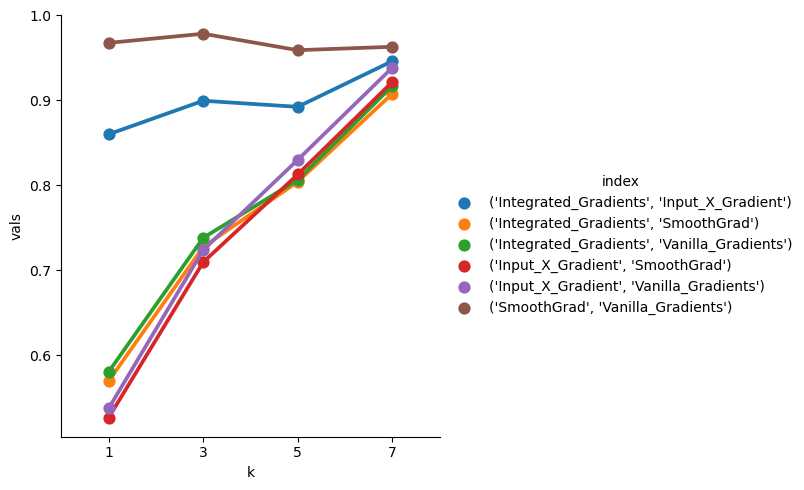

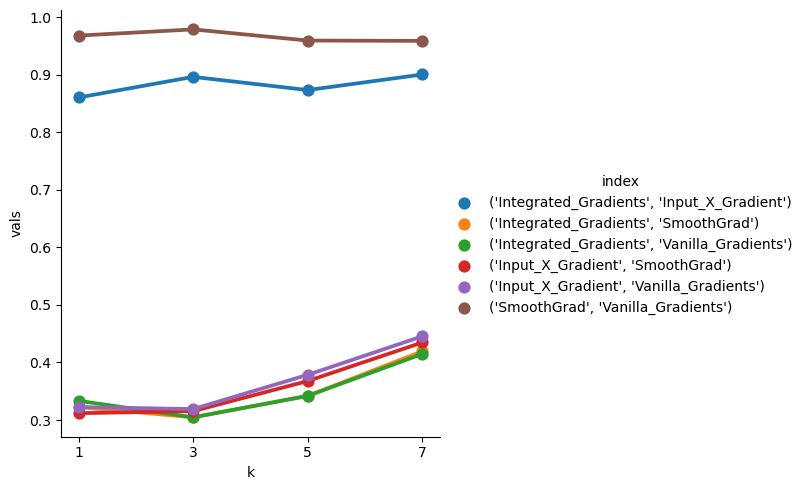

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax_count = 0

for metric_name, value in dfs.items():
    print(metric_name)
    df_mean = pd.DataFrame(index=dfs[metric_name][1].mean(axis=0).to_frame().index)
    for k in [1,3,5,7]:
        print(k)
        print(dfs[metric_name][k].mean(axis=0))
        df_mean[k] = dfs[metric_name][k].mean(axis=0).to_frame(name=k)[k]
    sns.heatmap(df_mean, cmap='Blues', annot=True, vmax=1, vmin=0, ax=axs[ax_count])
    axs[ax_count].set_xlabel('k')
    axs[ax_count].set_title('Metric: ' + metric_name)
    
    df_temp = df_mean.reset_index().melt('index', var_name='k',  value_name='vals')
    sns.catplot(x="k", y="vals", hue='index', data=df_temp, kind='point')
    
    ax_count+=1    
    print('\n\n ---------------------- \n')
plt.plot()

# Case 2: Agnostic explanation methods

In [18]:
explanation_methods

['Integrated_Gradients',
 'Input_X_Gradient',
 'SmoothGrad',
 'Vanilla_Gradients',
 'Guided_Backprop',
 'Occlusion',
 'Lime',
 'KernelShap',
 'DeepLift',
 'ShapleyValueSampling']

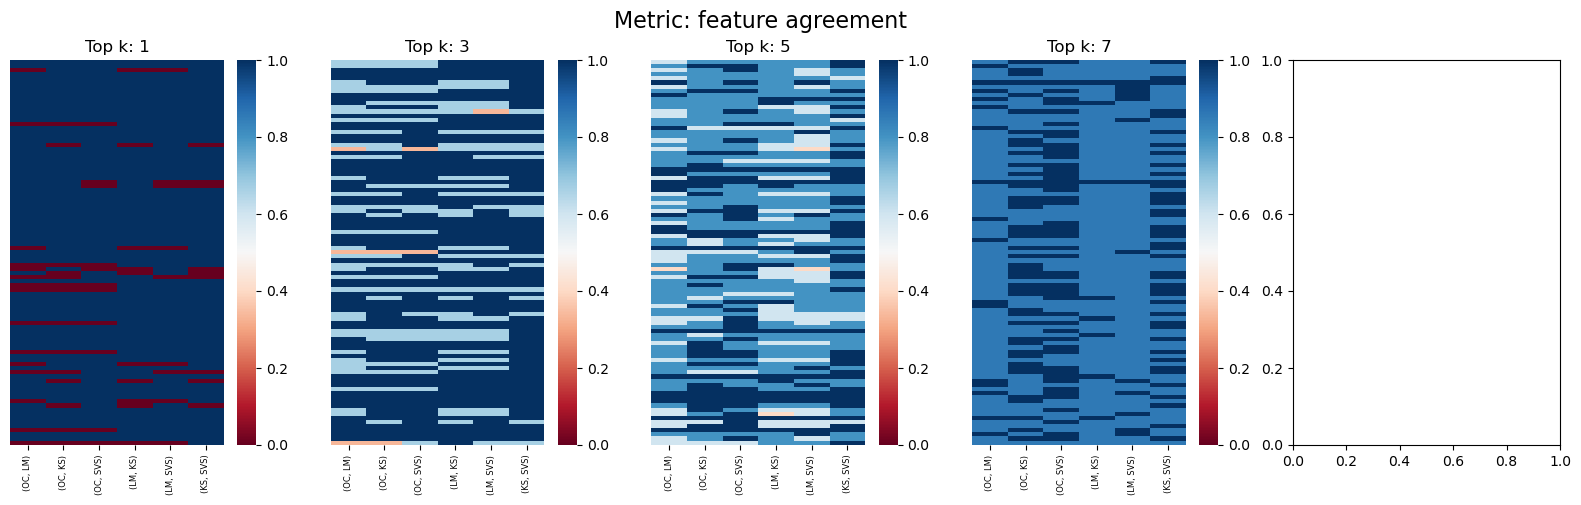

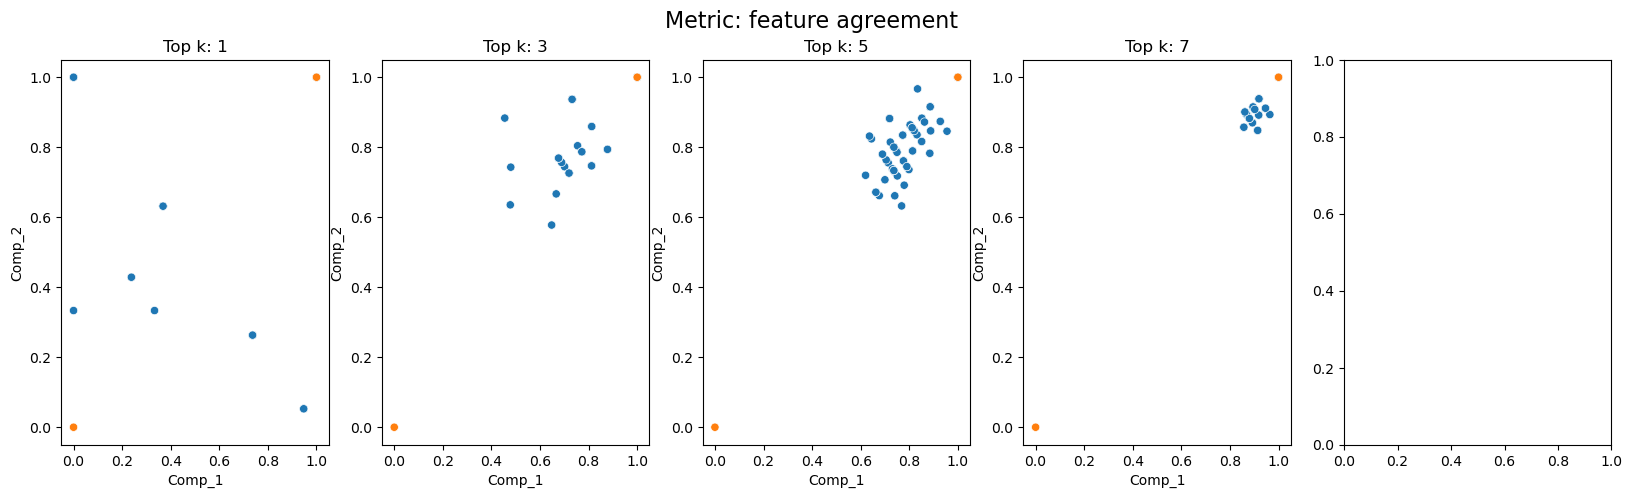

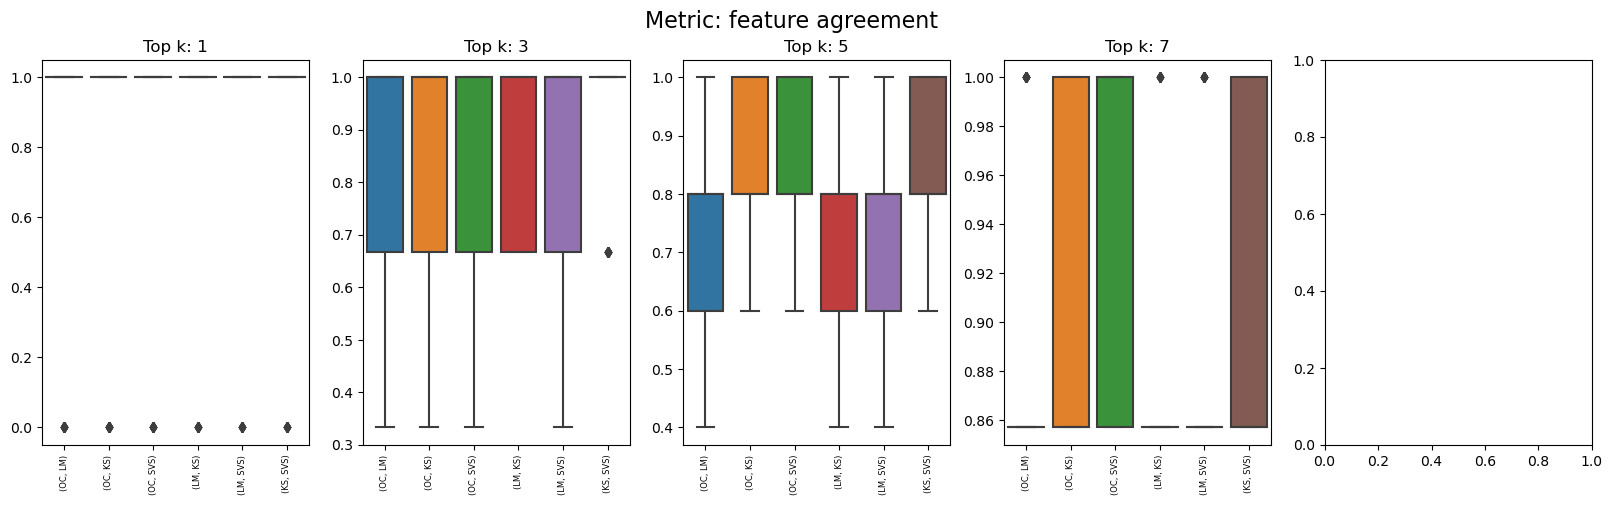

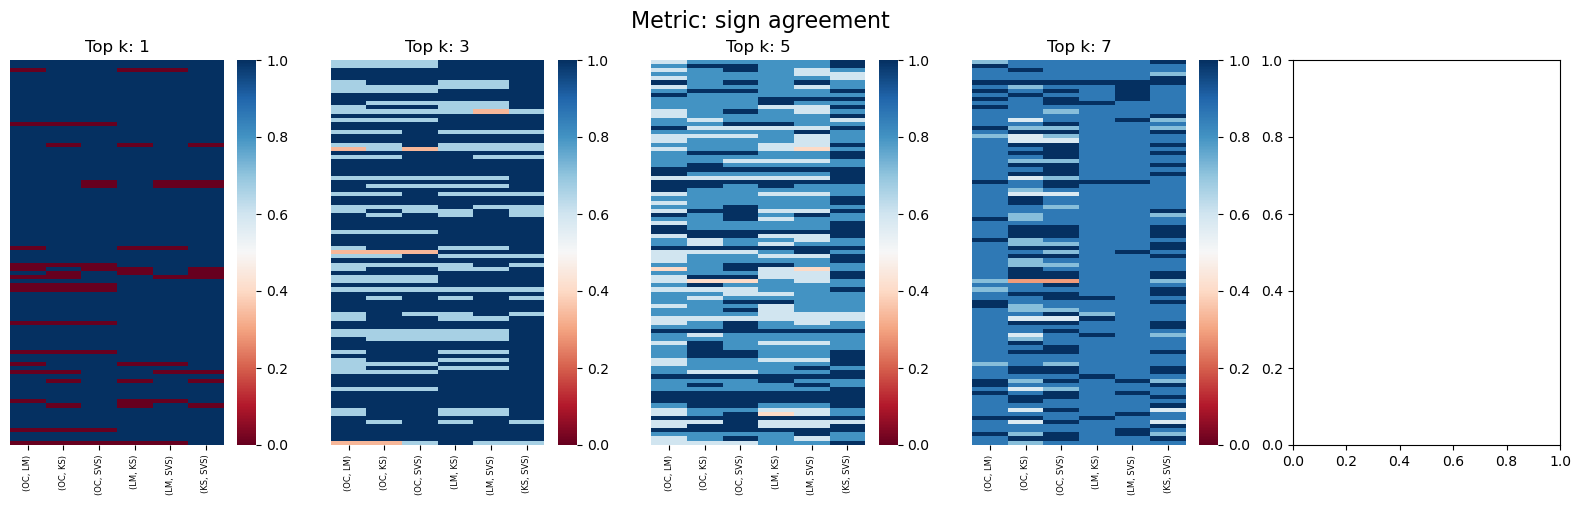

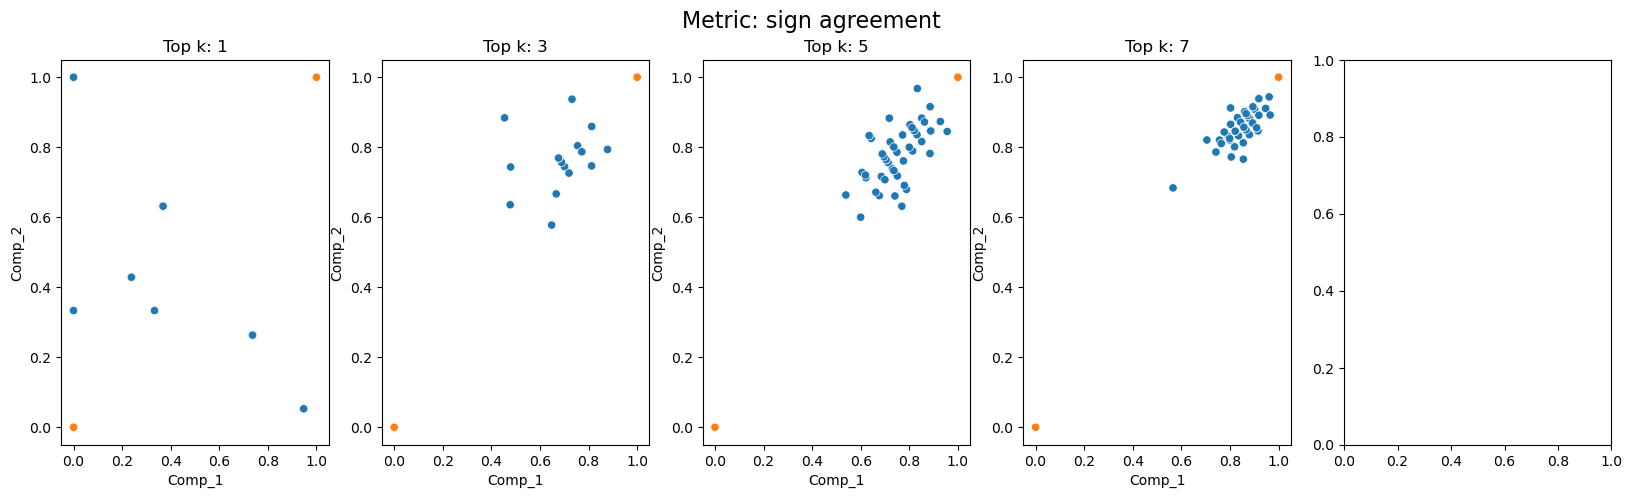

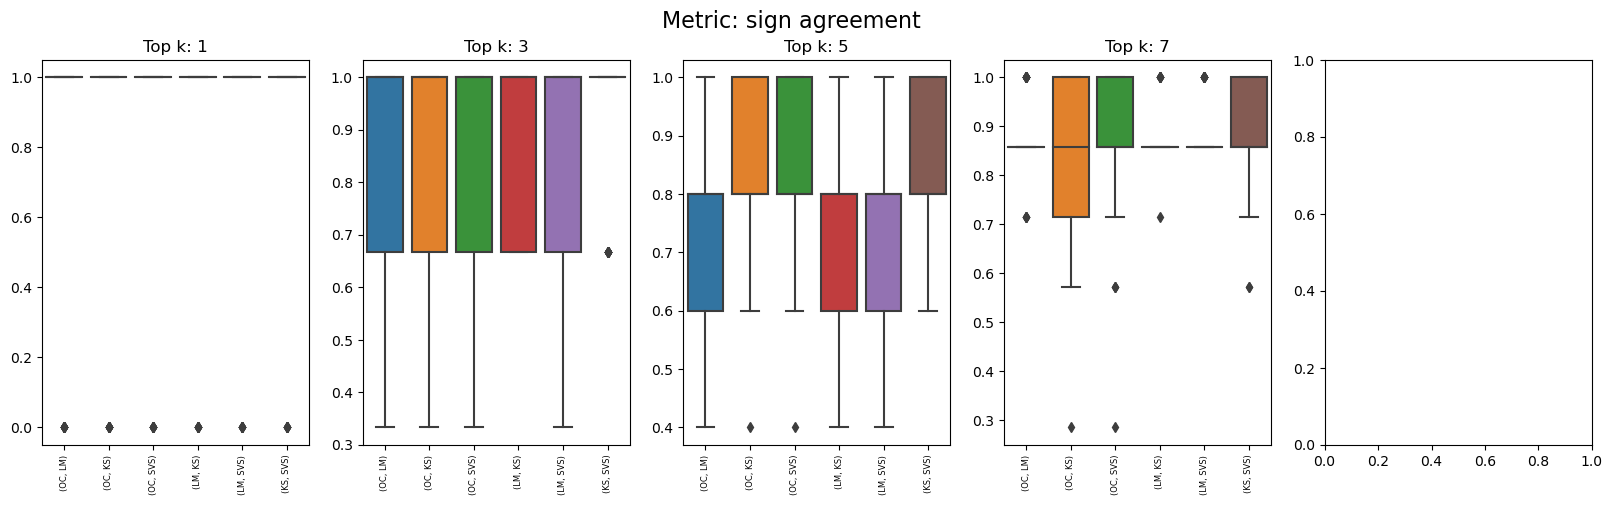

In [19]:
selected_methods = [explanation_methods[5], explanation_methods[6], explanation_methods[7], explanation_methods[9]]

dfs = {}

for metric_name, selected_metric in list_metrics.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig_space, axs_space = plt.subplots(1, 5, figsize=(20, 5))
    fig_boxplot, axs_boxplot = plt.subplots(1, 5, figsize=(20, 5))
    
    i = 0
    df_k = {}
    
    for selected_k in [1,3,5,7]:
        dict_topk = get_dict_topk(attr, explanation_methods, selected_k)
        matrix_points, list_combinations_methods = calc_metrics(selected_k, selected_methods, selected_metric, dict_topk)
        xticklabels = ['(OC, LM)', '(OC, KS)', '(OC, SVS)', '(LM, KS)', '(LM, SVS)', '(KS, SVS)']
        name_combinations_methods = [str(t) for t in list_combinations_methods]
        df = pd.DataFrame(matrix_points, columns=name_combinations_methods)
        
        df_k[selected_k] = df
        
        sns.heatmap(df, cmap='RdBu', ax=axs[i], vmax=1, vmin=0, xticklabels=xticklabels)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 90, fontsize = 6)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_title('Top k: ' + str(selected_k))        
        
        _, df_lamp = draw_lamp(matrix_points, axs_space[i])
        axs_space[i].set_title('Top k: ' + str(selected_k))
        
        sns.boxplot(data=df, ax=axs_boxplot[i])
        axs_boxplot[i].set_title('Top k: ' + str(selected_k))      
        axs_boxplot[i].set_xticklabels(xticklabels, rotation = 90, fontsize = 6)
        
        i+=1
        
    dfs[metric_name] = df_k
    fig.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_space.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_boxplot.suptitle('Metric: ' + metric_name, fontsize=16)
    plt.show()

In [20]:
df_temp = dfs['feature agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9]

,"('Occlusion', 'Lime')","('Occlusion', 'KernelShap')","('Occlusion', 'ShapleyValueSampling')","('Lime', 'KernelShap')","('Lime', 'ShapleyValueSampling')","('KernelShap', 'ShapleyValueSampling')",mean
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
86,1.0,1.0,1.0,1.0,1.0,1.0,1.0
87,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,1.0,1.0,1.0,1.0,1.0,1.0,1.0
90,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
df_temp = dfs['sign agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9]

,"('Occlusion', 'Lime')","('Occlusion', 'KernelShap')","('Occlusion', 'ShapleyValueSampling')","('Lime', 'KernelShap')","('Lime', 'ShapleyValueSampling')","('KernelShap', 'ShapleyValueSampling')",mean
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
86,1.0,1.0,1.0,1.0,1.0,1.0,1.0
87,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,1.0,1.0,1.0,1.0,1.0,1.0,1.0
90,1.0,1.0,1.0,1.0,1.0,1.0,1.0


feature agreement
1
('Occlusion', 'Lime')                     0.838710
('Occlusion', 'KernelShap')               0.849462
('Occlusion', 'ShapleyValueSampling')     0.881720
('Lime', 'KernelShap')                    0.892473
('Lime', 'ShapleyValueSampling')          0.903226
('KernelShap', 'ShapleyValueSampling')    0.903226
dtype: float64
3
('Occlusion', 'Lime')                     0.856631
('Occlusion', 'KernelShap')               0.885305
('Occlusion', 'ShapleyValueSampling')     0.906810
('Lime', 'KernelShap')                    0.892473
('Lime', 'ShapleyValueSampling')          0.899642
('KernelShap', 'ShapleyValueSampling')    0.942652
dtype: float64
5
('Occlusion', 'Lime')                     0.774194
('Occlusion', 'KernelShap')               0.849462
('Occlusion', 'ShapleyValueSampling')     0.879570
('Lime', 'KernelShap')                    0.780645
('Lime', 'ShapleyValueSampling')          0.769892
('KernelShap', 'ShapleyValueSampling')    0.881720
dtype: float64
7
('Occlusion

[]

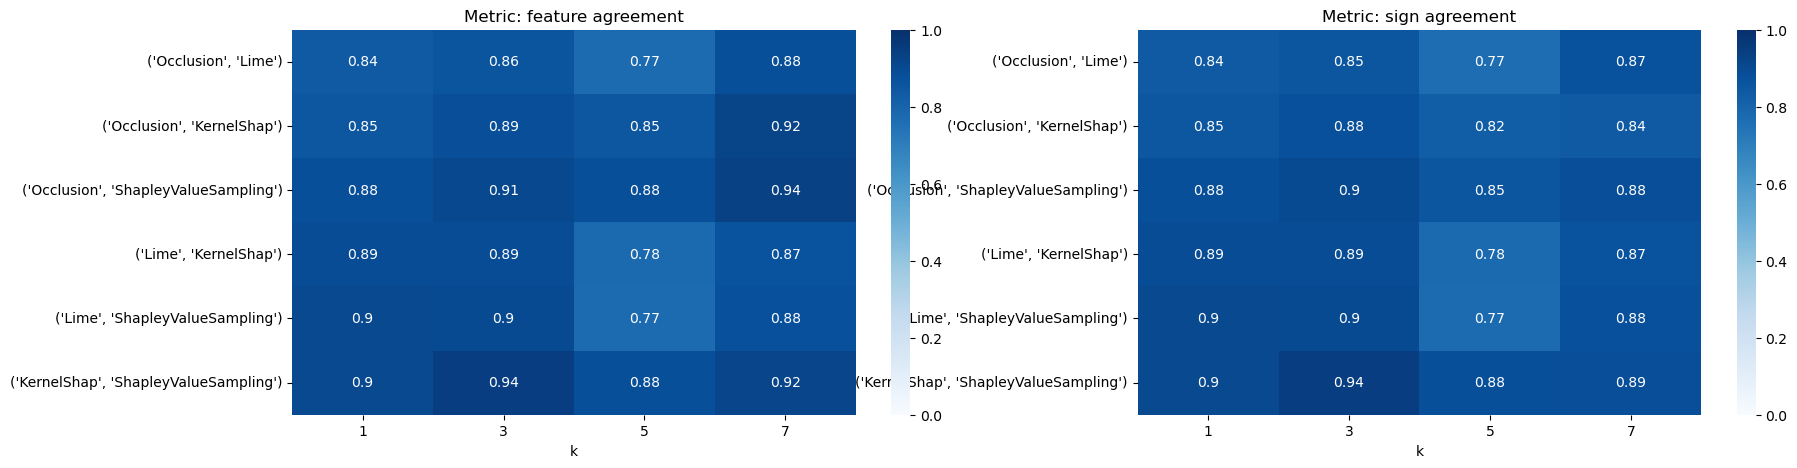

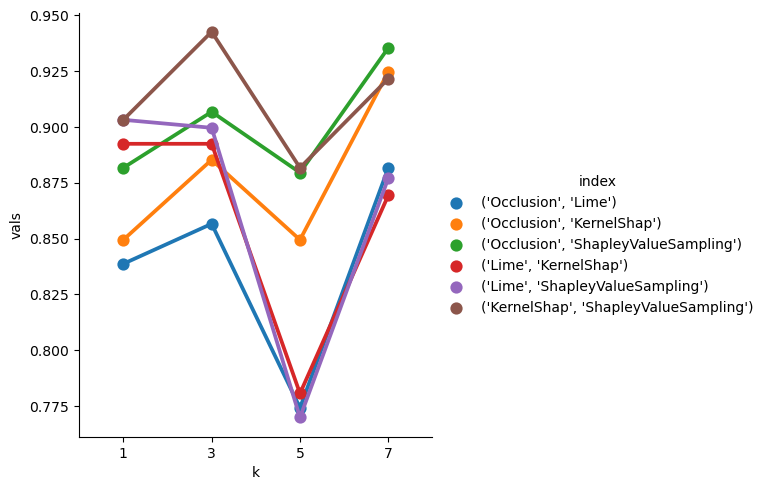

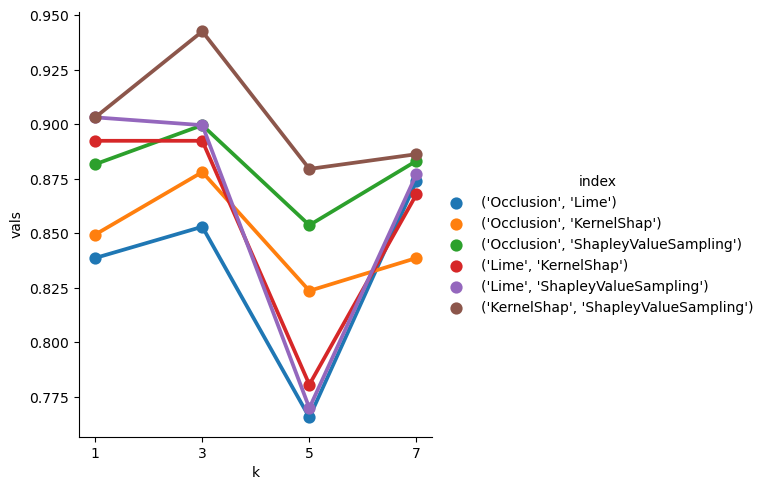

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax_count = 0

for metric_name, value in dfs.items():
    print(metric_name)
    df_mean = pd.DataFrame(index=dfs[metric_name][1].mean(axis=0).to_frame().index)
    for k in [1,3,5,7]:
        print(k)
        print(dfs[metric_name][k].mean(axis=0))
        df_mean[k] = dfs[metric_name][k].mean(axis=0).to_frame(name=k)[k]
        
    sns.heatmap(df_mean, cmap='Blues', annot=True, vmax=1, vmin=0, ax=axs[ax_count])
    axs[ax_count].set_xlabel('k')
    axs[ax_count].set_title('Metric: ' + metric_name)
    
    df_temp = df_mean.reset_index().melt('index', var_name='k',  value_name='vals')
    sns.catplot(x="k", y="vals", hue='index', data=df_temp, kind='point')
    
    ax_count+=1    
    print('\n\n ---------------------- \n')
plt.plot()

In [23]:
# df = df_mean.reset_index().melt('index', var_name='k',  value_name='vals')
# g = sns.catplot(x="k", y="vals", hue='index', data=df, kind='point')